# We will try here to define a bias score that is not biased by the county carateristics.

Each arrest contributing to the score of an officer will be ponderated by the parameters derivated from the stop's county's parameter.

We will try to apply the score on a small dataset for speed and memory before puting it onto a large one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

from tqdm import tqdm
tqdm.pandas()

import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Users\lenovo\Anaconda3\envs\ada\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
folder = '../data/'
state = folder + 'fl_statewide.csv.zip'
state_reduced = folder + 'fl_statewide_reduced.csv.zip'
state_cleared = folder + 'fl_statewide_cleared.csv.zip'

keep_columns = ['date', 'time', 'county_name', 'subject_age', 'subject_race', 'subject_sex', 'officer_id_hash', 'officer_age', 'officer_race', 'officer_sex', 'officer_years_of_service', 'arrest_made', 'citation_issued', 'warning_issued', 'frisk_performed', 'search_conducted']
mandatory_columns = ['date', 'time', 'subject_age', 'subject_race', 'subject_sex', 'officer_id_hash', 'officer_age', 'officer_race', 'officer_sex', 'officer_years_of_service', 'arrest_made', 'citation_issued', 'warning_issued', 'search_conducted']
minorities = ['white', 'hispanic', 'black']
boolean_columns = ['arrest_made', 'citation_issued', 'warning_issued', 'frisk_performed', 'search_conducted']

Load the data

In [3]:
# load all dataset
df = pd.read_csv(state_cleared)
print(len(df))

2808197


Drop the useless columns and correct types.

In [4]:
df.drop(columns=df.columns.difference(keep_columns), inplace=True) # drop unused columns
df.dropna(subset=mandatory_columns, how='any', inplace=True) # drop nan values in mandatory columns
df['date'] = pd.to_datetime(df['date']) # to datetime
df['year'] = df['date'].dt.to_period('y')

df = df[df['officer_race'].isin(minorities)]
print(len(df))

2808197


Ajouter moyenne par année civile pour gagner en précision avec le grand dataset.

In [5]:
def create_year_hash(df):
    df['officer_hash_year'] = df['officer_id_hash'] + '-' + df['year'].astype(str)

### There is an old index column to drop

In [6]:
create_year_hash(df)

We need to remove officers with too few arrests.

In [7]:
(df.groupby('officer_hash_year')['date'].count() > 300).mean()

0.5613053613053613

It seems that when we define a new officer each year, there are too few entries by hash. Let's keep one entry by officer for now, regardless of time. (On larger dataset, maybe possible to make the separation)

In [8]:
complete_df = df.copy()

In [9]:
stops_required = 300

officers_to_keep = df.groupby('officer_hash_year')['year'].count().loc[df.groupby('officer_hash_year')['year'].count() > stops_required].index

df = df[df.officer_hash_year.isin(officers_to_keep)]

print(len(df))

2456046


Test with a single minority here.

In [10]:
for minority in minorities:
    df[minority + '_stoped'] = (df['subject_race'] == minority)

In [11]:
county_means = {}
for minority in minorities:
    county_means[minority] = df.groupby('county_name')[minority + '_stoped'].mean()

In [49]:
def score_by_county(officer_df, minority, relative = True):
    county_stop_proportion_minority = officer_df.groupby('county_name')[minority + '_stoped'].mean()
    county_stop_count = officer_df.groupby('county_name')[minority + '_stoped'].count()
    county_stop_prop = county_stop_count/county_stop_count.sum()
    if (relative is True):
        return (((county_stop_proportion_minority - county_means[minority].loc[county_stop_proportion_minority.index])/county_means[minority].loc[county_stop_proportion_minority.index])*county_stop_prop).sum()
    else:
        return ((county_stop_proportion_minority - county_means[minority].loc[county_stop_proportion_minority.index])*county_stop_prop).sum()

In [50]:
scores = {}
for minority in tqdm(minorities):
    scores[minority] = df.groupby('officer_hash_year').apply(score_by_county, minority)

In [51]:
officer_numerics = ['officer_age', 'officer_years_of_service']
officer_cat = ['officer_race', 'officer_sex']

In [52]:
# Create a dataframe with the characteristics of officers.
officer_df = df.groupby('officer_hash_year')[officer_numerics].mean()

officer_df[officer_cat] = (df[['officer_hash_year'] + officer_cat].drop_duplicates()).set_index('officer_hash_year')

# Add the bias score
for minority in minorities:
    officer_df[minority + '_bias'] = scores[minority]

In [53]:
for minority in minorities:
    print()
    print(f'--------------{minority.upper()}--------------')
    res = smf.ols(formula=f'{minority}_bias ~ C(officer_race) + C(officer_sex) + officer_age + officer_years_of_service', data=officer_df).fit()
    print(res.summary())
    print()
    print()


--------------WHITE--------------
                            OLS Regression Results                            
Dep. Variable:             white_bias   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     11.55
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           4.31e-11
Time:                        12:52:24   Log-Likelihood:                 1244.8
No. Observations:                3612   AIC:                            -2478.
Df Residuals:                    3606   BIC:                            -2440.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

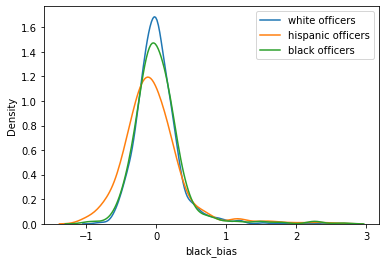

In [55]:
biases = ['white_bias', 'hispanic_bias', 'black_bias']
for m in minorities:
    sns.kdeplot(officer_df[officer_df['officer_race'] == m]['black_bias'], label = m + " officers")
plt.legend()
plt.show()

#### Let's look at the distributions based on other parameters

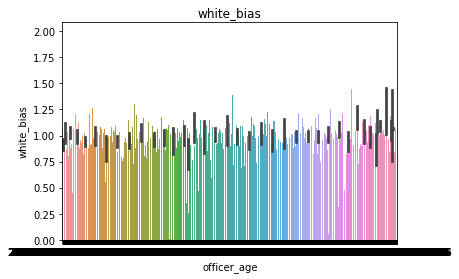

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001CFEAD15400> (for post_execute):


KeyboardInterrupt: 

In [139]:
biases = ['white_bias', 'hispanic_bias', 'black_bias']
for bias in biases:
    plt.figure()
    sns.barplot(x = officer_df['officer_age'], y = officer_df[bias] + 1)
    plt.title(bias)
    plt.show()

Affichage de l'experience plutôt

In [157]:
(officer_df['officer_years_of_service'].astype(int) >= 0).mean()

0.9950166112956811

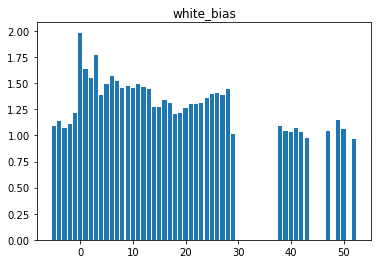

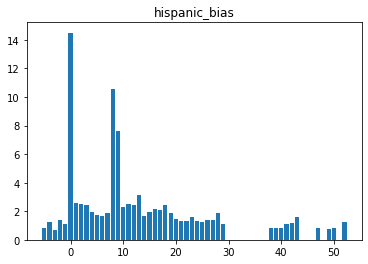

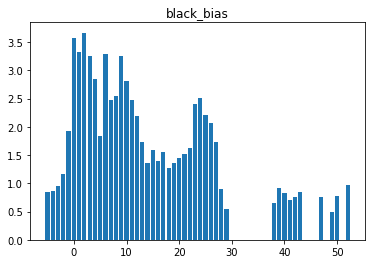

In [151]:
biases = ['white_bias', 'hispanic_bias', 'black_bias']
for bias in biases:
    plt.figure()
    plt.bar(x = officer_df['officer_years_of_service'].astype(int), height = officer_df[bias] + 1, )
    plt.title(bias)
    plt.show()

## Test of the PCA to see if there are clusters

In [57]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA(n_components=2)

In [59]:
projections = pca.fit_transform(officer_df[biases])

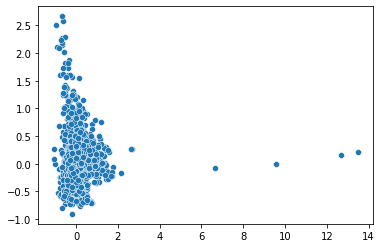

In [60]:
plt.figure()
sns.scatterplot(x = projections[:,0], y = projections[:,1])
plt.show()

In [61]:
from mpl_toolkits.mplot3d import axes3d


In [62]:
%matplotlib notebook

In [63]:
mapping = {'hispanic': 'y', 
          'black': 'k', 
          'white':'r'}
colors = [mapping[r] for r in officer_df['officer_race']]

<IPython.core.display.Javascript object>


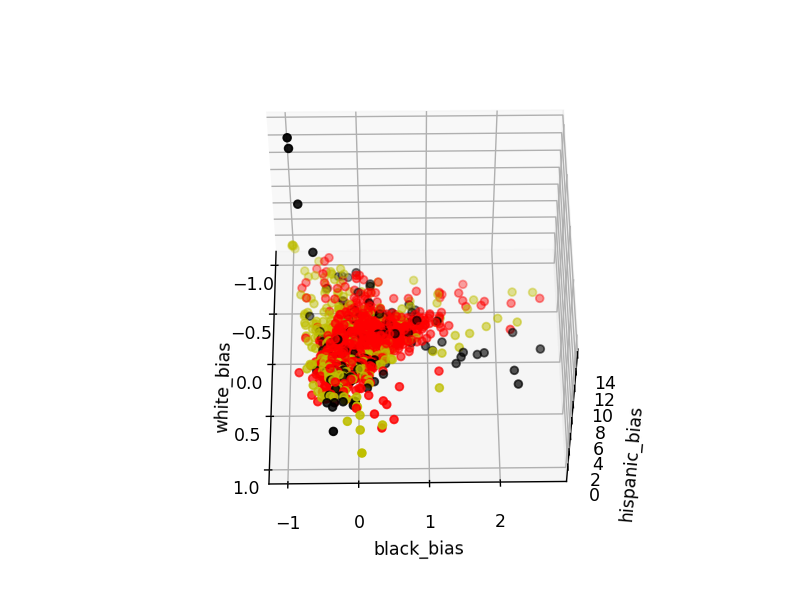

In [64]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(officer_df['white_bias'],officer_df['black_bias'], officer_df['hispanic_bias'] , color=colors)
ax.set_xlabel('white_bias')
ax.set_ylabel('black_bias')
ax.set_zlabel('hispanic_bias')
plt.show()

# Let's try without the relative difference but only the difference

In [65]:
scores_diff = {}
for minority in tqdm(minorities):
    scores_diff[minority] = df.groupby('officer_hash_year').apply(score_by_county, minority, False)

100%|██████████| 3/3 [01:42<00:00, 34.15s/it]


In [158]:
for minority in minorities:
    officer_df[minority + '_bias_diff'] = scores_diff[minority]

In [159]:
for minority in minorities:
    print()
    print(f'--------------{minority.upper()}--------------')
    res = smf.ols(formula=f'{minority}_bias_diff ~ C(officer_race) + C(officer_sex) + officer_age + officer_years_of_service', data=officer_df).fit()
    print(res.summary())
    print()
    print()


--------------WHITE--------------
                            OLS Regression Results                            
Dep. Variable:        white_bias_diff   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     12.99
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.49e-12
Time:                        16:59:27   Log-Likelihood:                 4235.7
No. Observations:                3612   AIC:                            -8459.
Df Residuals:                    3606   BIC:                            -8422.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [69]:
%matplotlib inline

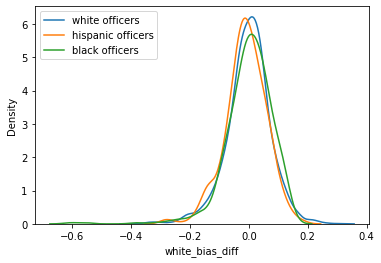

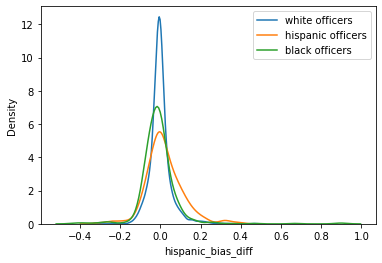

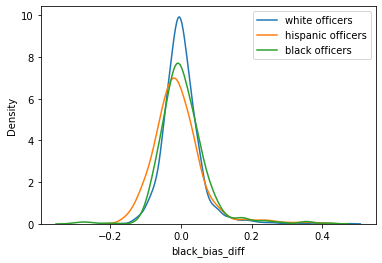

In [160]:
biases_diff = ['white_bias_diff', 'hispanic_bias_diff', 'black_bias_diff']
for bias in biases_diff:
    plt.figure()
    for m in minorities:
        sns.kdeplot(officer_df[officer_df['officer_race'] == m][bias], label = m + " officers")
    plt.legend()
    plt.show()

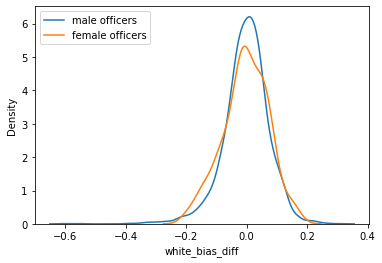

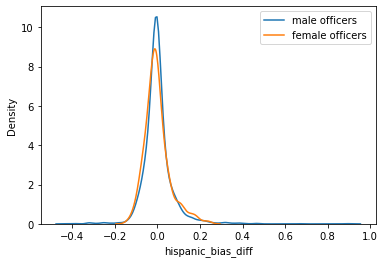

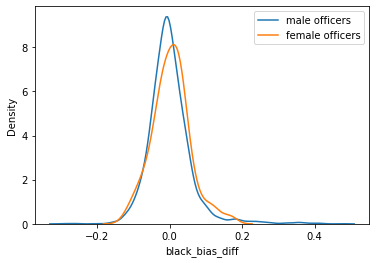

In [165]:
sexes = ['male', 'female']
for bias in biases_diff:
    plt.figure()
    for s in sexes:
        sns.kdeplot(officer_df[officer_df['officer_sex'] == s][bias], label = s + " officers")
    plt.legend()
    plt.show()

# Let's try to deal with the reasons for stops.

In [74]:
small = pd.read_csv(state_reduced)

In [ ]:
Traffic_violation = []

In [112]:
possible_reasons = list(small['reason_for_stop'].unique())
possible_reasons.pop(2) #remove nan

nan

In [123]:
for r in possible_reasons:
    if ('LIGHT' in r):
        print(r)

DRIVING WITHOUT HEADLIGHTS
DRIVING WITHOUT HEADLIGHTS|FAULTY EQUIPMENT


In [121]:
['VIOLATION']

['VIOLATION']

In [120]:
list((small['reason_for_stop'].value_counts()/len(small)).index)

['SPEED',
 'SEATBELT (DRIVER)',
 'CMV INSPECTION',
 'VIOLATIONS OF TRAFFIC CONTROL DEVICE',
 'FAULTY EQUIPMENT',
 'OTHER MOVING VIOLATIONS',
 'EXPIRED TAG (- MONTHS OR LESS)',
 'MOVE OVER LAW',
 'WINDOW TINT',
 'OTHER TAG / REGISTRATION VIOLATIONS',
 'OTHER NON MOVING VIOLATIONS',
 'IMPROPER CHANGE OF LANE OR COURSE',
 'IMPROPER PASSING',
 'FOLLOWING TOO CLOSELY',
 'IMPROPER TURN',
 'DRIVING WITHOUT HEADLIGHTS',
 'SEATBELT (PASSENGER)',
 'EXPIRED TAG (MORE THAN - MONTHS)',
 'VIOLATIONS OF RIGHT OF WAY',
 'CARELESS DRIVING',
 'TOLL EVASION',
 'WEIGHT VIOLATION',
 'LOADS ON VEHICLE',
 'OBSTRUCTING THE ROADWAY',
 'NO REGISTRATION',
 'ATTACHING TAG NOT ASSIGNED',
 'DRIVING ON WRONG SIDE OF ROAD',
 'DRIVING WHILE LICENSE SUSPENDED / REVOKED',
 'IMPROPER BACKING',
 'PARKING',
 'EXHAUST SYSTEM',
 'RECKLESS DRIVING',
 'DUI',
 'CHILD RESTRAINT',
 'OTHER CRIMINAL TRAFFIC VIOLATIONS',
 'MAXIMUM WIDTH, HEIGHT AND LENGTH',
 'OTHER CRIMINAL VIOLATIONS',
 'FAILURE TO EXHIBIT DL UPON DEMAND',
 'EXPIRE

In [113]:
possible_reasons

['SPEED',
 'EXPIRED TAG (- MONTHS OR LESS)',
 'WINDOW TINT',
 'VIOLATIONS OF TRAFFIC CONTROL DEVICE',
 'FAULTY EQUIPMENT',
 'SEATBELT (DRIVER)',
 'MOVE OVER LAW',
 'CMV INSPECTION',
 'IMPROPER PASSING',
 'OTHER NON MOVING VIOLATIONS',
 'OTHER MOVING VIOLATIONS',
 'CARELESS DRIVING',
 'OTHER TAG / REGISTRATION VIOLATIONS',
 'FOLLOWING TOO CLOSELY',
 'IMPROPER CHANGE OF LANE OR COURSE',
 'OPEN CONTAINER (DRIVER)',
 'SEATBELT (PASSENGER)',
 'IMPROPER TURN',
 'WEIGHT VIOLATION',
 'OTHER CRIMINAL TRAFFIC VIOLATIONS',
 'EXPIRED DRIVERS LICENSE (MORE THAN - MONTHS)',
 'EXPIRED TAG (MORE THAN - MONTHS)',
 'DRIVING WITHOUT HEADLIGHTS',
 'VIOLATIONS OF RIGHT OF WAY',
 'IMPROPER BACKING',
 'DRIVING ON WRONG SIDE OF ROAD',
 'NO DRIVERS LICENSE',
 'LOADS ON VEHICLE',
 'NO REGISTRATION',
 'BICYCLE VIOLATIONS',
 'MOTOR VEHICLE NOISE',
 'OBSTRUCTING THE ROADWAY',
 'PARKING',
 'TOLL EVASION',
 'ATTACHING TAG NOT ASSIGNED',
 'EXHAUST SYSTEM',
 'PROOF OF INSURANCE|SPEED',
 'MAXIMUM WIDTH, HEIGHT AND LENG

In [85]:
for r in small['reason_for_stop'].unique():
    print(r)
    if ('speed' in r):
        print(r)

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [166]:
officer_df

,officer_age,officer_years_of_service,officer_race,officer_sex,white_bias,hispanic_bias,black_bias,white_bias_diff,hispanic_bias_diff,black_bias_diff
officer_hash_year,,,,,,,,,,
000f298db7-2010,33.523109,10.000000,hispanic,male,0.196926,-0.093764,-0.310023,0.100208,-0.021395,-0.054092
000f298db7-2011,34.285211,10.705399,hispanic,male,0.300791,-0.208955,-0.378602,0.149251,-0.053390,-0.067213
000f298db7-2012,35.288248,11.776053,hispanic,male,0.159085,-0.033828,-0.370043,0.078911,-0.009923,-0.064353
000f298db7-2013,36.338481,12.767053,hispanic,male,0.292987,-0.238387,-0.373989,0.145292,-0.063512,-0.066214
000f298db7-2014,37.334917,13.823436,hispanic,male,0.182949,-0.123526,-0.272897,0.089630,-0.034280,-0.047603
...,...,...,...,...,...,...,...,...,...,...
ff49b13b30-2015,30.230769,1.184615,white,male,-0.027689,-0.184142,0.220945,-0.020065,-0.016667,0.029511
ff557f58ba-2011,35.897436,9.452214,black,male,0.188139,-0.561722,2.248547,0.026350,-0.378546,0.351782
ff557f58ba-2012,36.824503,10.350993,black,male,0.025611,-0.426435,1.820238,0.004944,-0.286799,0.283929
